# [IAPR 2019:][iapr2019] Lab 2 ‒  Object description

**Author:** Luca Fetz & Mohammed-Ismail Ben Salah 
**Due date:** 19.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [75]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Description
In the `lab-02-data/` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

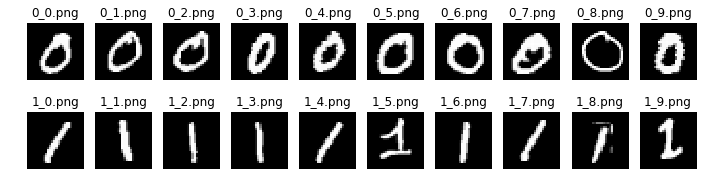

In [76]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
In this implementation of fourier descriptors we first binarized the image, then extracted the contours of our numbers and resampled them so that they are all of the same length. This is done so that the results of the fft will be comparable. We then converted the coordinates of the contours to complex number and applied a fft to produce our fourier descriptors.

When the fourier descriptors are ready, we plot the result to see how well our descriptors differentiate the different numbers. We avoid using f0 to be invariant to translation. We use the magnitude and not the phase so that we are invariant to rotation. Here every image is at the same scale, so it wasn't considered necessary to be invariant to scaling. The results when plotting on descriptors f1 against f5 are pretty good. All the points are well grouped except 1 of each class. Just to test, we also plotted the ratio between 2 fourier descriptors in order to be invariant to scaling. This representation however gives us 2 additional badly placed points. 

To assess the effect of rotation we will run the same script on rotated images in the next cell.


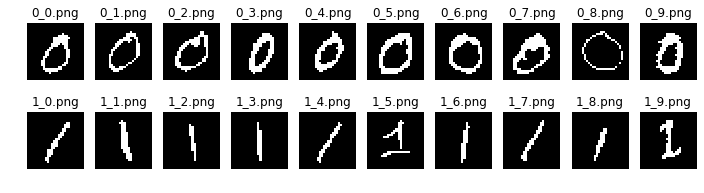

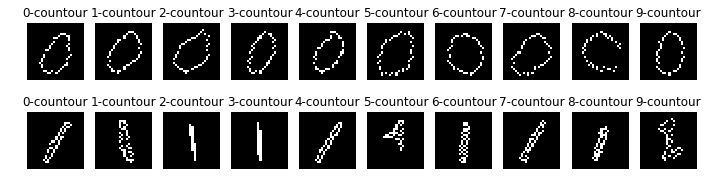

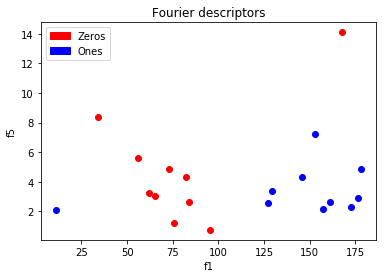

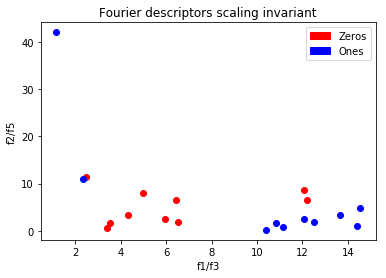

In [89]:
# u_k = x_k + j y_k

# Import stuff
import numpy as np
from skimage.filters import threshold_minimum
from scipy.fftpack import fft, ifft
from skimage.measure import find_contours
from scipy.signal import resample
from skimage.transform import rotate

#extract number of images and number of pixels
N_images, dim,_ = zeros_im.shape

# Morphological stuff

#binarize images and count number of points to be in descriptor
zeros_im_bin = zeros_im.copy()
min_thres  = threshold_minimum(zeros_im_bin)
cust_thres = 230
zeros_im_bin = zeros_im_bin > cust_thres

ones_im_bin = ones_im.copy()
min_thres = threshold_minimum(ones_im_bin)
ones_im_bin = ones_im_bin > cust_thres
            
# Convert to uint8 
zeros_im_bin = zeros_im_bin * 255
ones_im_bin = ones_im_bin * 255

#visualize binarization
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im_bin, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im_bin, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
plt.show()
    
zeros_contours = []
ones_contours = []

# Find countours fo each image
for idx in range(0,N_images):
    # Find countours return multiples iso-v
    zero_countour = find_contours(zeros_im_bin[idx],128,fully_connected='high',positive_orientation='low')
    zeros_contours.append(zero_countour)
    one_countour = find_contours(ones_im_bin[idx],128,fully_connected='high',positive_orientation='low')
    ones_contours.append(one_countour)


def convert_countour_to_image(dim_img,countour):
    img_countour = np.zeros((dim_img,dim_img))
    np_countour = np.around(countour).astype(int) # Round the coordinates
    for coord_elem in np_countour:
        row = coord_elem[0]
        col = coord_elem[1]
        img_countour[row,col] = 255
    return img_countour

#for idx in range(0,N_images):
#    for countour in ones_contours[idx]:
#        fig, ax = plt.subplots(1, figsize=(12, 3))
#        ax.imshow(convert_countour_to_image(dim,countour), cmap='gray')
#        ax.axis('off')
#        ax.set_title('{}-countour'.format(idx))    
        
# Keep only the first contours of each image
zeros_unique_countours = []
for idx in range(0,N_images):
    zeros_unique_countours.append(zeros_contours[idx][0])
# Keep only the first contours of each image
ones_unique_countours = []
for idx in range(0,N_images):
        ones_unique_countours.append(ones_contours[idx][0])


# Print the length of a countour and take the minimum length
#print("zero len")
#for idx,elem in enumerate(zeros_unique_countours):
#    print("Image N°{} has length : {}".format(idx,len(elem)))

#print("one len")
#for idx,elem in enumerate(ones_unique_countours):
#    print("Image N°{} has length : {}".format(idx,len(elem)))
    
zero_ctr_min_length = min([len(x) for x  in zeros_unique_countours])
ones_ctr_min_length = min([len(x) for x  in ones_unique_countours])
min_ctr_length = min(zero_ctr_min_length,ones_ctr_min_length)

#Resamples all signals
zeros_resampled = []
ones_resampled = []

for idx in range(0,N_images):
    zeros_resampled.append(resample(zeros_unique_countours[idx],min_ctr_length))
    ones_resampled.append(resample(ones_unique_countours[idx],min_ctr_length))


    

fig, ax = plt.subplots(2,N_images, figsize=(12, 3))
for idx in range(0,N_images):
        ax[0,idx].imshow(convert_countour_to_image(dim,zeros_resampled[idx]), cmap='gray')
        ax[0,idx].axis('off')
        ax[0,idx].set_title('{}-countour'.format(idx))
        ax[1,idx].imshow(convert_countour_to_image(dim,ones_resampled[idx]), cmap='gray')
        ax[1,idx].axis('off')
        ax[1,idx].set_title('{}-countour'.format(idx))
plt.show()

    
def conv_to_complex(xy):
    c=xy[:,0]+1j*xy[:,1]
    return c

# Convert x-y to complex number
cplx_zeros_resampled = []
cplx_ones_resampled = []
for idx in range(0,N_images):
    cplx_zeros_resampled.append(conv_to_complex(zeros_resampled[idx])) 
    cplx_ones_resampled.append(conv_to_complex(ones_resampled[idx])) 
    

# Generate fourier descriptors
zeros_fft_desc = []
ones_fft_desc  = []
for idx in range(0,N_images):
    zeros_fft_desc.append(fft(cplx_zeros_resampled[idx]))
    ones_fft_desc.append(fft(cplx_ones_resampled[idx]))
    
#backup the descriptors just to compare in next cell
zeros_fft_desc_backup = zeros_fft_desc
ones_fft_desc_backup = ones_fft_desc

# Plot the fourier descriptors
for idx,elem in enumerate(ones_fft_desc):
    plt.plot(abs(zeros_fft_desc[idx][1]),abs(zeros_fft_desc[idx][5]),'ro')
    plt.plot(abs(ones_fft_desc[idx][1]),abs(ones_fft_desc[idx][5]),'bo')
    
red_patch = mpatches.Patch(color='red', label='Zeros')
blue_patch = mpatches.Patch(color='blue', label='Ones')
plt.legend(handles=[red_patch,blue_patch])
plt.title('Fourier descriptors')
plt.xlabel('f1')
plt.ylabel('f5')
plt.show()

# Plot the fourier descriptors
for idx,elem in enumerate(ones_fft_desc):
    plt.plot(abs(zeros_fft_desc[idx][1])/abs(zeros_fft_desc[idx][3]),abs(zeros_fft_desc[idx][2])/abs(zeros_fft_desc[idx][5]),'ro')
    plt.plot(abs(ones_fft_desc[idx][1])/abs(ones_fft_desc[idx][3]),abs(ones_fft_desc[idx][2])/abs(ones_fft_desc[idx][5]),'bo')
    
red_patch = mpatches.Patch(color='red', label='Zeros')
blue_patch = mpatches.Patch(color='blue', label='Ones')
plt.legend(handles=[red_patch,blue_patch])
plt.title('Fourier descriptors scaling invariant')
plt.xlabel('f1/f3')
plt.ylabel('f2/f5')
plt.show()

#### Visualize rotation invariance. 
Here we applied the same script to see the fourier descriptors of the images rotated by 180°. We can see that the result is aproximately the same, thenks to the rotation invariance. There are some small differences due to the fact that after rotating the image the contours will fit a little bit differently. It also induces a big change in image of one N°5 (after rotation it became one N°4). When the image is upside down the detected contour is the base of the 1 where the contour detected the rest before. Therefore this point is quite different from before.

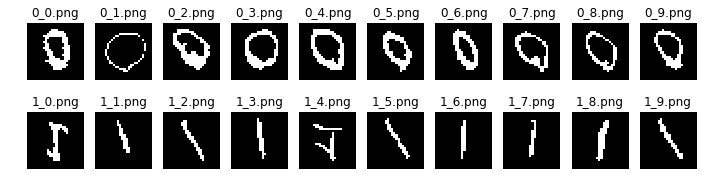

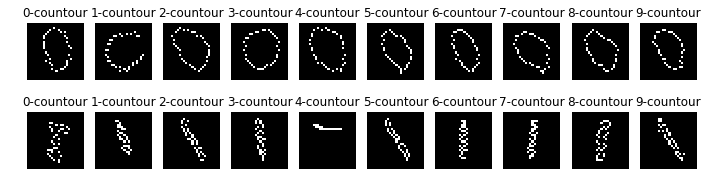

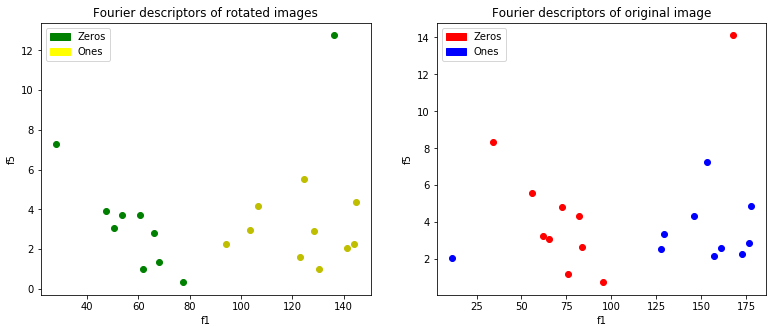

In [92]:
# u_k = x_k + j y_k

# Import stuff
import numpy as np
from skimage.filters import threshold_minimum
from scipy.fftpack import fft, ifft
from skimage.measure import find_contours
from scipy.signal import resample
from skimage.transform import rotate

#extract number of images and number of pixels
N_images, dim,_ = zeros_im.shape

# Morphological stuff

#binarize images and count number of points to be in descriptor
zeros_im_bin = rotate(zeros_im.copy(),180,resize=True, center=None, order=1, mode='wrap', cval=0, clip=True, preserve_range=True)
min_thres  = threshold_minimum(zeros_im_bin)
cust_thres = 230
zeros_im_bin = zeros_im_bin > cust_thres

ones_im_bin = rotate(ones_im.copy(),180,resize=True, center=None, order=1, mode='wrap', cval=0, clip=True, preserve_range=True)
min_thres = threshold_minimum(ones_im_bin)
ones_im_bin = ones_im_bin > cust_thres
            
# Convert to uint8 
zeros_im_bin = zeros_im_bin * 255
ones_im_bin = ones_im_bin * 255

#visualize binarization
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im_bin, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im_bin, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
plt.show()
    
zeros_contours = []
ones_contours = []

# Find countours fo each image
for idx in range(0,N_images):
    # Find countours return multiples iso-v
    zero_countour = find_contours(zeros_im_bin[idx],128,fully_connected='high',positive_orientation='low')
    zeros_contours.append(zero_countour)
    one_countour = find_contours(ones_im_bin[idx],128,fully_connected='high',positive_orientation='low')
    ones_contours.append(one_countour)


def convert_countour_to_image(dim_img,countour):
    img_countour = np.zeros((dim_img,dim_img))
    np_countour = np.around(countour).astype(int) # Round the coordinates
    for coord_elem in np_countour:
        row = coord_elem[0]
        col = coord_elem[1]
        img_countour[row,col] = 255
    return img_countour

#for idx in range(0,N_images):
#    for countour in ones_contours[idx]:
#        fig, ax = plt.subplots(1, figsize=(12, 3))
#        ax.imshow(convert_countour_to_image(dim,countour), cmap='gray')
#        ax.axis('off')
#        ax.set_title('{}-countour'.format(idx))    
        
# Keep only the first contours of each image
zeros_unique_countours = []
for idx in range(0,N_images):
    zeros_unique_countours.append(zeros_contours[idx][0])
# Keep only the first contours of each image
ones_unique_countours = []
for idx in range(0,N_images):
        ones_unique_countours.append(ones_contours[idx][0])


# Print the length of a countour and take the minimum length
#print("zero len")
#for idx,elem in enumerate(zeros_unique_countours):
#    print("Image N°{} has length : {}".format(idx,len(elem)))

#print("one len")
#for idx,elem in enumerate(ones_unique_countours):
#    print("Image N°{} has length : {}".format(idx,len(elem)))
    
zero_ctr_min_length = min([len(x) for x  in zeros_unique_countours])
ones_ctr_min_length = min([len(x) for x  in ones_unique_countours])
min_ctr_length = min(zero_ctr_min_length,ones_ctr_min_length)

#Resamples all signals
zeros_resampled = []
ones_resampled = []

for idx in range(0,N_images):
    zeros_resampled.append(resample(zeros_unique_countours[idx],min_ctr_length))
    ones_resampled.append(resample(ones_unique_countours[idx],min_ctr_length))


    

fig, ax = plt.subplots(2,N_images, figsize=(12, 3))
for idx in range(0,N_images):
        ax[0,idx].imshow(convert_countour_to_image(dim,zeros_resampled[idx]), cmap='gray')
        ax[0,idx].axis('off')
        ax[0,idx].set_title('{}-countour'.format(idx))
        ax[1,idx].imshow(convert_countour_to_image(dim,ones_resampled[idx]), cmap='gray')
        ax[1,idx].axis('off')
        ax[1,idx].set_title('{}-countour'.format(idx))
plt.show()

    
def conv_to_complex(xy):
    c=xy[:,0]+1j*xy[:,1]
    return c

# Convert x-y to complex number
cplx_zeros_resampled = []
cplx_ones_resampled = []
for idx in range(0,N_images):
    cplx_zeros_resampled.append(conv_to_complex(zeros_resampled[idx])) 
    cplx_ones_resampled.append(conv_to_complex(ones_resampled[idx])) 
    

# Generate fourier descriptors
zeros_fft_desc = []
ones_fft_desc  = []
for idx in range(0,N_images):
    zeros_fft_desc.append(fft(cplx_zeros_resampled[idx]))
    ones_fft_desc.append(fft(cplx_ones_resampled[idx]))
    
# Plot the fourier descriptors
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
for idx,elem in enumerate(ones_fft_desc):
    plt.subplot(121)
    plt.plot(abs(zeros_fft_desc[idx][1]),abs(zeros_fft_desc[idx][5]),'go')
    plt.plot(abs(ones_fft_desc[idx][1]),abs(ones_fft_desc[idx][5]),'yo')
    plt.subplot(122)
    plt.plot(abs(zeros_fft_desc_backup[idx][1]),abs(zeros_fft_desc_backup[idx][5]),'ro')
    plt.plot(abs(ones_fft_desc_backup[idx][1]),abs(ones_fft_desc_backup[idx][5]),'bo')
    
plt.subplot(121)

red_patch = mpatches.Patch(color='green', label='Zeros')
blue_patch = mpatches.Patch(color='yellow', label='Ones')
plt.legend(handles=[red_patch,blue_patch])
plt.title('Fourier descriptors of rotated images')
plt.xlabel('f1')
plt.ylabel('f5')
plt.subplot(122)
red_patch = mpatches.Patch(color='red', label='Zeros')
blue_patch = mpatches.Patch(color='blue', label='Ones')
plt.legend(handles=[red_patch,blue_patch])
plt.title('Fourier descriptors of original image')
plt.xlabel('f1')
plt.ylabel('f5')
plt.show()


### 1.3 Additional method(s)
Add your implementation and discussion

#### 1.3.1 Simple region based descriptors
In the next cell various simple region based descriptors were implemented.

In all cases the image was first binarized. Then, the perimeter was measured as the length of the contour found by the method find_contours. To measure the area a morphological closing was applied to the images in order to close the gaps in the zeros and simply compute the area as the number of white pixels. We settled for a disk of size 6 as a structuring element. It is large enough to close all the zeros except one. We tried a bigger disk but then border effects appeared and falsified the area measure. The compacity was then computed from perimeter and area.

All 3 region based descriptors give good results. As they are only 1D descriptors they were plotted in 2D just to put them on a diagonal and be more visible. The value is the same on both axis. The compacity is invariant to rotation, translation and scaling so it gives the best properties. But in our case, it does not give the best separation in the clusters because of the Zero image whose gap is not filled and therefore has a compacity similar to the ones. The best separation is provided by the area. This descriptor is still invariant to translation and rotation, so it is a very good descriptor if we consider all our images have the same scale. 

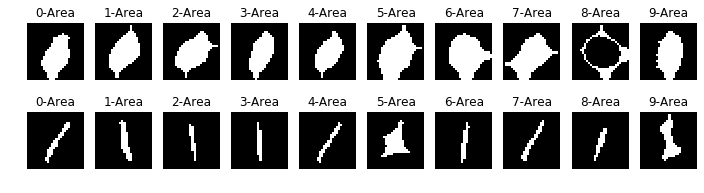

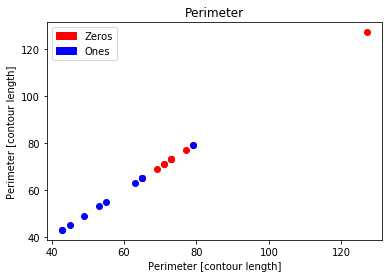

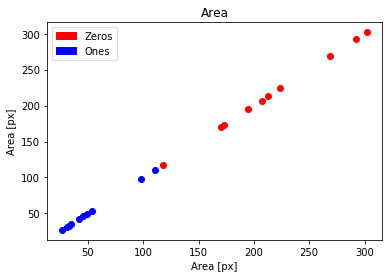

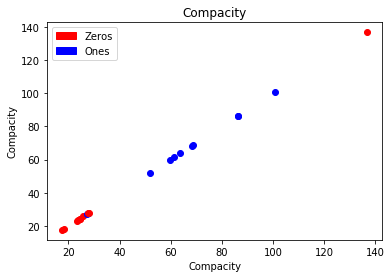

In [93]:
import skimage.morphology as morph
#extract number of images and number of pixels
N_images, N,tmp = zeros_im.shape

#binarize images
cust_thres = 230
zeros_im_bin = zeros_im.copy()
zeros_im_bin = zeros_im_bin > cust_thres

ones_im_bin = ones_im.copy()
ones_im_bin = ones_im_bin > cust_thres

# Convert to uint8 
zeros_im_bin = zeros_im_bin * 255
ones_im_bin  = ones_im_bin * 255

#morphology for area computation
full_zeros = []
full_ones = []
area_zeros = []
area_ones = []
area_tmp_zeros = 0
area_tmp_ones = 0
struct_elem = morph.disk(6)
for i in range(0,N_images):
    full_zeros.append(morph.closing(zeros_im_bin[i],struct_elem))
    full_ones.append(morph.closing(ones_im_bin[i],struct_elem))
    
for i in range(0,N_images):
    area_tmp_zeros = 0
    area_tmp_ones = 0
    for j in range(0,N):
        for k in range(0,N):
            if full_zeros[i][j,k] == 255:
                area_tmp_zeros = area_tmp_zeros+1
            if full_ones[i][j,k] == 255:
                area_tmp_ones = area_tmp_ones+1
    area_zeros.append(area_tmp_zeros)
    area_ones.append(area_tmp_ones)
    

fig, ax = plt.subplots(2,N_images, figsize=(12, 3))
for idx in range(0,N_images):
        ax[0,idx].imshow(full_zeros[idx], cmap='gray')
        ax[0,idx].axis('off')
        ax[0,idx].set_title('{}-Area'.format(idx))
        ax[1,idx].imshow(full_ones[idx], cmap='gray')
        ax[1,idx].axis('off')
        ax[1,idx].set_title('{}-Area'.format(idx))
plt.show()

#contour_zeros will be a list of lists of ndarrays with the coordinates of the contour
#access it with contour_zeros[im_idx,arra_idx,]
contour_zeros = []
contour_ones = []
for i in range(0,N_images):
    contour_zeros.append(find_contours(zeros_im_bin[i], 128, fully_connected='high', positive_orientation='low'))
    contour_ones.append(find_contours(ones_im_bin[i], 128, fully_connected='high', positive_orientation='low'))
    

#plot perimeter
for i in range(0,N_images):
    plt.plot(len(contour_zeros[i][0]),len(contour_zeros[i][0]),'ro',len(contour_ones[i][0]),len(contour_ones[i][0]),'bo')

red_patch = mpatches.Patch(color='red',label='Zeros')
blue_patch = mpatches.Patch(color='blue', label='Ones')
plt.legend(handles=[red_patch,blue_patch])
plt.title('Perimeter')
plt.xlabel('Perimeter [contour length]')
plt.ylabel('Perimeter [contour length]')
plt.show()

#plot area
for i in range(0,N_images):
    plt.plot(area_zeros[i],area_zeros[i],'ro',area_ones[i],area_ones[i],'bo')
    
red_patch = mpatches.Patch(color='red',label='Zeros')
blue_patch = mpatches.Patch(color='blue', label='Ones')
plt.legend(handles=[red_patch,blue_patch])
plt.title('Area')
plt.xlabel('Area [px]')
plt.ylabel('Area [px]')
plt.show()

#plot compacity
for i in range(0,N_images):
    plt.plot(((len(contour_zeros[i][0]))**2) /(area_zeros[i]),((len(contour_zeros[i][0]))**2) /(area_zeros[i]),'ro',((len(contour_ones[i][0]))**2) /(area_ones[i]),((len(contour_ones[i][0]))**2) /(area_ones[i]),'bo')

green_patch = mpatches.Patch(color='red',label='Zeros')
blue_patch = mpatches.Patch(color='blue', label='Ones')
plt.legend(handles=[green_patch,blue_patch])
plt.title('Compacity')
plt.xlabel('Compacity')
plt.ylabel('Compacity')
plt.show()